# **Denoising Diffusion Probabilistic Models**
**Made by Anas Aldadi**

![forward and backward processes](https://drive.google.com/uc?id=1-EkQX1ssPdNStQAeeRTT2e4bhOEy2r6x)

## Requirements

In [ ]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import glob
import os, re, shutil
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image as IPImage
import torch.nn.functional as F
import gc
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import clear_output
!pip install torchinfo
!pip install -q diffusers
!pip install -U gdown

clear_output()
from torchinfo import summary
import diffusers

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import gdown
folder_id = "1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1-EkQX1ssPdNStQAeeRTT2e4bhOEy2r6x forward_and_reverse.png
Processing file 11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX latent_CDDPM.pth


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-EkQX1ssPdNStQAeeRTT2e4bhOEy2r6x
To: /content/DDPMs/forward_and_reverse.png
100%|██████████| 286k/286k [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX
To: /content/DDPMs/latent_CDDPM.pth
100%|██████████| 6.98M/6.98M [00:00<00:00, 110MB/s]
Download completed


['/content/DDPMs/forward_and_reverse.png', '/content/DDPMs/latent_CDDPM.pth']

## Helper functions

In [ ]:
def latent_interpolation_gif(model, steps, output_path, device, attrs, latent_dim=16, scale_size=512, framerate=10):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    z_start = torch.randn(1, latent_dim).to(device)
    z_end = torch.randn(1, latent_dim).to(device)

    temp_img_dir = os.path.join(os.path.dirname(output_path), "frames")
    os.makedirs(temp_img_dir, exist_ok=True)

    for step in range(steps):
        alpha = step / (steps - 1)
        z_interp = (1 - alpha) * z_start + alpha * z_end

        #decode with fixed attributes
        generated= model.decoder(z_interp, attrs)

        #convert to numpy image
        generated_img = generated.cpu().detach().numpy()[0]  # (3, 128, 128)
        img = np.moveaxis(generated_img, 0, -1)  # CHW to HWC
        img = (img * 255).astype(np.uint8)

        frame_path = os.path.join(temp_img_dir, f"frame_{step:03d}.png")
        Image.fromarray(img).save(frame_path)
        print(f'temp_img_dir {temp_img_dir}')
        print(f"saved {frame_path}")

    time.sleep(2)
    gif_command = f'ffmpeg -y -framerate {framerate} -i {temp_img_dir}/frame_%03d.png -vf "scale={scale_size}:-1" {output_path}'
    os.system(gif_command)

    print(f"GIF saved to {output_path}")

In [ ]:
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()

    images, attr = next(iter(dataloader))
    images = images[:num_images].to(device)
    attr = attr[:num_images].to(device)

    with torch.no_grad():
        reconstructions, _, _ = model(images, attr)
    reconstructions = reconstructions.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze().permute(1,2,0).numpy())
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructions[i].squeeze().permute(1,2,0).numpy())
        axes[1, i].axis('off')

    axes[0, 0].set_title('original images', fontsize=12)
    axes[1, 0].set_title('reconstructed images', fontsize=12)
    plt.show()

def show_image(image):
    plt.imshow(image.cpu().detach().permute(1,2,0).numpy())
    plt.axis('off')

def showImage(x, model, latent_dim, device):
    attrs = torch.Tensor(x)
    img = model.decoder(torch.randn(1,latent_dim).to(device), attrs.to(device))
    img = img[0].cpu().detach().permute(1,2,0).numpy()
    return img

In [ ]:
@torch.no_grad()
def sample_images(model, noise_scheduler, num_samples, device, attrs=None):
    model.eval()
    #start from pure noise
    x = torch.randn(num_samples, 3, 128, 128).to(device)

    #if no attrs provided, randomly sample (hair:0-3, beard:0/1, gender:0/1, paleSkin:0/1)
    if attrs is None:
        attrs = torch.randint(0, 4, (num_samples, 1))  # hair
        beard = torch.randint(0, 2, (num_samples, 1))
        gender = torch.randint(0, 2, (num_samples, 1))
        pale = torch.randint(0, 2, (num_samples, 1))
        attrs = torch.cat([attrs, beard, gender, pale], dim=1).to(device)
    else:
        attrs = attrs.to(device)

    for t in tqdm(reversed(range(noise_scheduler.config.num_train_timesteps)), desc="Sampling"):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        #predict noise
        noise_pred = model(x, t_batch, attrs)

        #scheduler (takes a scalar timestep not a batch)
        x = noise_scheduler.step(noise_pred, t, x).prev_sample


    # x is now the generated image in [-1, 1], scale it to [0, 1] for visualization
    x = (x.clamp(-1, 1) + 1) / 2
    return x  # shape (num_samples, 3, 128, 128)

In [ ]:
@torch.no_grad()
def gender_morph_diffusion(model, noise_scheduler, steps, device, base_attrs, latent_dim=128):
    model.eval()
    images = []
    #fix the same random noise for smooth morphing
    x = torch.randn(1, 3, 128, 128).to(device)

    for i in tqdm(range(steps), desc="Morphing Gender"):
        alpha = i / (steps - 1)

        #interpolate gender between Female (0) and Male (1)
        gender_value = alpha
        #embeddings inside model, interpolate embeddings
        #for simple version: floor gender
        gender = torch.tensor([[int(round(gender_value))]]).to(device)

        attrs = torch.cat([
            base_attrs[:, 0:1],   # hair
            base_attrs[:, 1:2],   # beard
            gender,               # interpolated gender
            base_attrs[:, 3:4],   # pale skin
        ], dim=1)

        #denoising loop
        x_t = x.clone()
        for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
            t_batch = torch.full((1,), t, device=device, dtype=torch.long)
            noise_pred = model(x_t, t_batch, attrs)
            x_t = noise_scheduler.step(noise_pred, t, x_t).prev_sample

        final_img = (x_t.clamp(-1, 1) + 1) / 2
        images.append(final_img.cpu())

    return images  #torch tensors (1, 3, 128, 128)

In [ ]:
@torch.no_grad()
def sample_and_visualize(
    model, noise_scheduler, num_samples, device, attrs, vis_step=100
):
    model.eval()
    x = torch.randn(num_samples, 3, 128, 128).to(device)
    saved_images = []

    total_steps = noise_scheduler.config.num_train_timesteps

    for t in tqdm(reversed(range(total_steps)), desc="Sampling"):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch, attrs)
        x = noise_scheduler.step(noise_pred, t, x).prev_sample

        if t % vis_step == 0 or t == 0:
            saved_images.append((x.clamp(-1, 1) + 1) / 2)

    return saved_images

## Data

Pretty much like the data preprocessing in the VAE Tutorial

### Downloading the data

In [ ]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [00:07<00:00, 195MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/jessicali9530/celeba-dataset/versions/2


In [ ]:
path = '/content/data/datasets/jessicali9530/celeba-dataset/versions/2'
root = path+'/img_align_celeba/img_align_celeba'
attr_file = '/content/data/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv'
root

'/content/data/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

### seeing the attributes we gonna do the conditioning

In [ ]:
import pandas as pd

df = pd.read_csv('/content/data/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv')

#### Extracting the attributes i am interested at

In [ ]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3

df["Hair_Color"] = df.apply(haircolor,axis=1)

In [ ]:
df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]

In [ ]:
"""
replacing -1 with 0 without affecting the the 1 values
"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))

<ipython-input-13-aa329b7d36ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
<ipython-input-13-aa329b7d36ba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Male = df.Male.apply(lambda x: max(x,0))


In [ ]:
np_attr_matrix = df.to_numpy()[:, 1:]
np_attr = np_attr_matrix.astype(np.float32)
np_attr

array([[1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [3., 0., 1., 1.],
       ...,
       [2., 0., 1., 1.],
       [2., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

### defining the transfroms and the cusom data class

In [ ]:
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

In [ ]:
class CustomData(Dataset):
    def __init__(self, root, attr_matrix, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

        #cleaning the attributes
        self.attributes = torch.from_numpy(attr_matrix).to(torch.float32)

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)

        attr = self.attributes[idx]

        return img, attr

datasett = CustomData(root, np_attr, transforms)
len(datasett)

202599

### Dataloader

In [ ]:
print(num_worker:=os.cpu_count())
train_dl = DataLoader(datasett, batch_size=32, num_workers=num_worker, persistent_workers=True)

12


(np.float64(-0.5), np.float64(1041.5), np.float64(261.5), np.float64(-0.5))

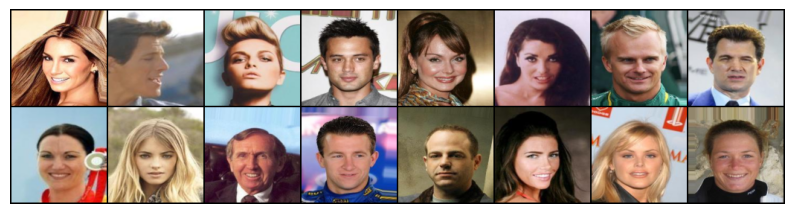

In [ ]:
x, y = next(iter(train_dl))
grid_img = torchvision.utils.make_grid(x[::2], nrow=8,normalize=True)
plt.figure(figsize=(10,6))
plt.imshow(grid_img.permute(1,2,0))
plt.axis('off')

In [ ]:
x[::8].shape, x[:8].shape

(torch.Size([4, 3, 128, 128]), torch.Size([8, 3, 128, 128]))

## Model and scheduler

I will use vanilla Denoising Diffusion Probabilistic Models (DDPMs) to train and generate images, which is computationally expensive and tricky to guide it into the desired direction to generate good images, but for the sake of understanding what the hell are DDPMs I will use the most simple vanilla thing ever. Both in archeticture and scheduler.


---


### DDPM Noise Scheduler Formula

In DDPM, we define a **variance schedule** `β₁, β₂, ..., βₜ`, where each `βₜ ∈ (0, 1)`. From these, we compute:

#### 1. Forward process `q(x_t | x_{t-1})` and `q(x_t | x₀)` (Stochastic process)

Don't get intimidated by this notation — it's pretty simple!  

- `x₀`: the original clean image  
- `x_t`: the noisy image at time step `t`  
- `x_{t-1}`: the same image with slightly less noise (i.e., from one step before)

again `x₀` is the original clean image, and `xₜ` is the noisy image at timestep `t`.  
`x_{t-1}` means the image at the previous timestep with slightly less noise.  
The forward process gradually adds Gaussian noise using the following formulas:

This process is called **"the forward diffusion process"**, and it adds noise step-by-step:

```
q(x_t | x_{t-1}) = N(x_t; √(1 - βₜ) * x_{t-1}, βₜ * I)
q(x_t | x₀) = N(x_t; √(1-βₜ) * x₀, (βₜ) * I)
```

A cleaner look at the forward process:

![noise scheduler](https://drive.google.com/uc?id=1bwSahrFSX9KOC2QSi_BTFIeYHNV9WIya)

Where
- `βₜ is the variance at timestep t`
- `I is the identity matrix`

The second equation is useful because it lets us sample `x_t` directly from `x₀` in one step.

---

#### 2. Sampling with the noise scheduler (Deterministic process)

Unlike the forward process defines a Markov chain where noise is gradually added to x₀ step-by-step:

- `x₁ ~ q(x₁ | x₀)`

- `x₂ ~ q(x₂ | x₁)`

- `...`

- `x_T ~ q(x_T | x_{T-1})`

the noise scheduler formula is a way to simulate or analytically generate the noisy image at any timestep, without running the full chain.

however it doesn't mean its better or anything but it is a closed form that has its purposes and the forward process is how we actually add noise during training.

Continuing... To simulate a noisy image at timestep `t`:

```
x_t = √(ᾱₜ) * x₀ + √(1 - ᾱₜ) * ε
```

Where
- `αₜ = 1 - βₜ`  
- `ᾱₜ = ∏_{s=1}^{t} α_s` (the product of all `α`s up to timestep `t`)
- `ε ~ N(0, I)`

a Cleaner look at noise scheduler:

![noise scheduler](https://drive.google.com/uc?id=1SYcoocGiK1dhPaxMzVJsplBMyLd94YEP)
For an intuitive explanation, see this [video](https://youtu.be/I1sPXkm2NH4?si=8xmtjK1hiJqtsXT7).

good source: [mastering DDPMs](https://medium.com/@lmpo/mastering-denoising-diffusion-probabilistic-models-8654cb6f6eff)

In [ ]:
#@title To give credict where credit is due, this archeticture was taken from this course: https://johnowhitaker.github.io/tglcourse/dm1.html
# I made modifications to incorporate conditioning on hair, beard, gender, paleness attributes
class ClassConditionedUnet(nn.Module):
  def __init__(self, class_emb_size=4, latent_dim=16):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.hair_emb = nn.Embedding(4, class_emb_size)
    self.beard_emb = nn.Embedding(2, class_emb_size)
    self.gender_emb = nn.Embedding(2, class_emb_size)
    self.pale_emb = nn.Embedding(2, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=128,           # the target image resolution
        in_channels=3 + latent_dim, # Additional input channels for class cond.
        out_channels=3,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )
    self.latent_dim = latent_dim

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, attrs):
    # Shape of x:
    bs, ch, w, h = x.shape

    hair_emb = self.hair_emb(attrs[:, 0].long())
    beard_emb = self.beard_emb(attrs[:, 1].long())
    gender_emb = self.gender_emb(attrs[:, 2].long())
    pale_emb = self.pale_emb(attrs[:, 3].long())

    cond_vector = torch.cat([hair_emb, beard_emb, gender_emb, pale_emb], dim=1)  # (bs, latent_dim)

    # Reshape conditioning to spatial map
    cond_map = cond_vector.view(bs, self.latent_dim, 1, 1).expand(bs, self.latent_dim, w, h)

    # x is shape (bs, 3, 128, 128) and class_cond is now (bs, 3+latent, 128, 128)
    net_input = torch.cat((x, cond_map), dim=1)  # (bs, 3+latent_dim, H, W)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
net = ClassConditionedUnet()

In [ ]:
img = torch.randn(2, 3, 128, 128) # random image
t = torch.randint(0, 1000, (2,)) # random noise time step
attr = torch.tensor([
    [1, 0, 1, 0],  # hair, beard, gender, pale_skin
    [2, 1, 0, 1]
])                 # random attributes

output = net(img, t, attr)
print(output.shape)

torch.Size([2, 3, 128, 128])


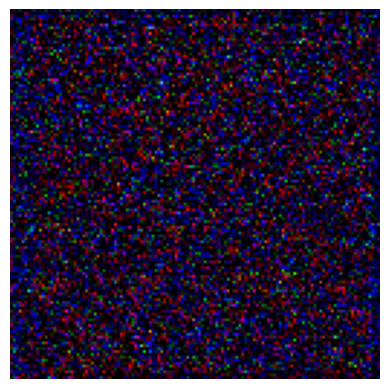

In [ ]:
show_image(output[0])

In [ ]:
summary(net.cpu(), input_data=[img, t, attr])

Layer (type:depth-idx)                             Output Shape              Param #
ClassConditionedUnet                               [2, 3, 128, 128]          --
├─Embedding: 1-1                                   [2, 4]                    16
├─Embedding: 1-2                                   [2, 4]                    8
├─Embedding: 1-3                                   [2, 4]                    8
├─Embedding: 1-4                                   [2, 4]                    8
├─UNet2DModel: 1-5                                 [2, 3, 128, 128]          --
│    └─Timesteps: 2-1                              [2, 32]                   --
│    └─TimestepEmbedding: 2-2                      [2, 128]                  16,512
│    │    └─Linear: 3-1                            [2, 128]                  4,224
│    └─UNetMidBlock2D: 2-97                        --                        (recursive)
│    │    └─ModuleList: 3-101                      --                        (recursive)
│    └─Timest

In [ ]:
print(f'number of parameters: {sum(p.numel() for p in net.parameters())}')

number of parameters: 1712811


In [ ]:
net.to(device)

ClassConditionedUnet(
  (hair_emb): Embedding(4, 4)
  (beard_emb): Embedding(2, 4)
  (gender_emb): Embedding(2, 4)
  (pale_emb): Embedding(2, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_s

## Training

In [ ]:
epochs=1
learning_rate=0.001
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
losses = []

Before we train the U-Net to generate images, let's dive right into the reverse process.

The reason i put the reverse process here is how dense it is to understand and grasp the forward process of DDPMs, also to let you see how the ordinary process of building the model and defining the hyperparams are still the same but the clever trick is in the training loop.

#### 2. Reverse process `p(x_{t-1} | x_t)`

Now that we've defined how we *add* noise step-by-step in the **forward process**, the goal of the model is to *reverse* that process — meaning:  
given a noisy image `x_t`, we want to predict what the slightly cleaner version `x_{t-1}` looked like.

This is the **denoising (reverse) diffusion process**, defined as:

```
p(x_{t-1} | x_t) = N(x_{t-1}; μ_θ(x_t, t), Σ_θ(x_t, t))
```

Where:

- `μ_θ(x_t, t)` is the mean predicted by the model (often conditioned on time step `t`)
- `Σ_θ(x_t, t)` is the variance (can be fixed or learned)
- `θ` represents the learnable parameters (e.g., weights of a neural network)

To simplify training, we don't train the model to predict `x_{t-1}` directly.  
Instead, we train it to predict the *noise* `ε` that was added to `x₀`:

```
x_t = √(ᾱₜ) * x₀ + √(1 - ᾱₜ) * ε
```

Then we recover `x₀` (and indirectly `x_{t-1}`) from the predicted noise:

```
ε_θ(x_t, t) ≈ ε   -->   x₀ ≈ (x_t - √(1 - ᾱₜ) * ε_θ) / √(ᾱₜ)
```

This lets us build the denoising process from `x_T` (pure noise) all the way back to a clean image `x₀`.

---

In summary:
- Forward: Add noise step-by-step.
- Reverse: Use a neural network to **predict the noise**, then reverse the process step-by-step.

In [ ]:
for epoch in range(epochs):
    for x, attrs in tqdm(train_dl):

        #move data to GPU
        x = x.to(device) * 2 - 1
        attrs = attrs.to(device)  # shape (B, 4)

        #prepare noisy input
        noise = torch.randn_like(x) #randomly sample a noise
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)#take a random timestep
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)#corrupt the input

        #forward pass with attributes as condition
        pred = net(noisy_x, timesteps, attrs)  # attrs are the conditioning vector now
        #we are not predicting an image here rather the noise

        #loss is still w.r.t. the noise
        loss = loss_fn(pred, noise)

        #backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

100%|██████████| 6332/6332 [1:42:57<00:00,  1.03it/s]

Finished epoch 0. Average of the last 100 loss values: 0.024096


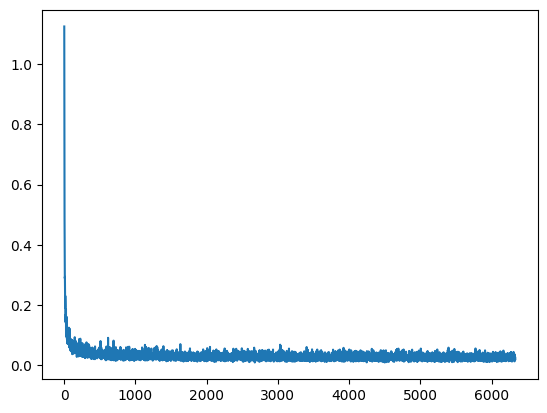

In [ ]:
plt.plot(losses)

In [ ]:
losses[-1]

0.019725820049643517

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/latent_CDDPM.pth') # latent was 64

## Loading the model

In [ ]:
model = ClassConditionedUnet().to(device)

https://drive.google.com/file/d/11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX/view?usp=sharing

In [ ]:
https://drive.google.com/drive/folders/1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx?usp=sharing

In [ ]:
!wget -O data_folder "https://drive.google.com/uc?id=1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx"

--2025-05-06 07:36:56--  https://drive.google.com/uc?id=1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx
Resolving drive.google.com (drive.google.com)... 142.251.183.113, 142.251.183.101, 142.251.183.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.183.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx [following]
--2025-05-06 07:36:56--  https://drive.usercontent.google.com/download?id=1Yd9YMJkfolpuVw80ZhVhKhCBt1t_3kKx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2025-05-06 07:36:58 ERROR 500: Internal Server Error.



In [ ]:
!wget -O latent_CDDPM.pth "https://drive.google.com/uc?id=11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX"

--2025-05-06 07:03:59--  https://drive.google.com/uc?id=11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX
Resolving drive.google.com (drive.google.com)... 142.251.183.100, 142.251.183.101, 142.251.183.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.183.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX [following]
--2025-05-06 07:03:59--  https://drive.usercontent.google.com/download?id=11FWx8Nd2CgT3B_ZLtjI9klJ0RF7YytmX
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6975628 (6.7M) [application/octet-stream]
Saving to: ‘latent_CDDPM.pth’

latent_CDDPM.pth    100%[===================>]   6.65M  --.-KB/s    in 0.07s   

2025-05-06 07:04:03 (98

In [ ]:
state_dict = torch.load('/content/latent_CDDPM.pth', map_location=device)

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## generate images

Sampling: 1000it [00:39, 25.28it/s]


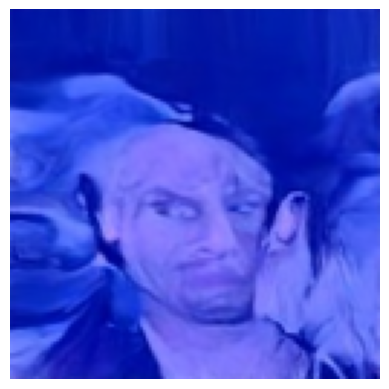

In [ ]:
generated_images = sample_images(model, noise_scheduler, num_samples=1, device=device, attrs= torch.tensor([[3,0,1,1]]))

img = generated_images[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(521.5), np.float64(131.5), np.float64(-0.5))

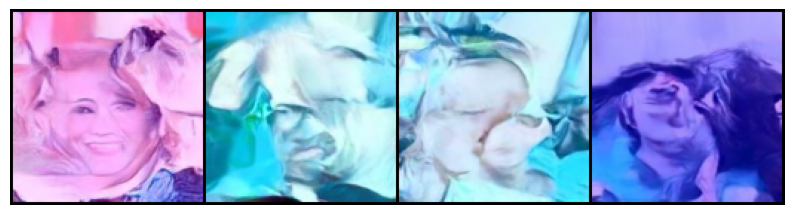

In [ ]:
grid_img = torchvision.utils.make_grid(generated_images.cpu(), nrow=8,normalize=True)
plt.figure(figsize=(10,6))
plt.imshow(grid_img.permute(1,2,0))
plt.axis('off')

In [ ]:
base_attrs = torch.tensor([[2, 0, 0, 1]]).to(device)  # Start female
images = gender_morph_diffusion(model,
                                noise_scheduler,
                                steps=50,
                                device=device,
                                base_attrs=base_attrs)

In [ ]:
images = sample_and_visualize(
    model=model,
    noise_scheduler=noise_scheduler,
    num_samples=4,
    device=device,
    attrs=torch.tensor([[3, 0, 1, 1]] * 4).to(device),
    vis_step=100  #save every 100 steps
)


Sampling: 1000it [00:59, 16.76it/s]


In [ ]:
# images: list of (B, 3, H, W) at each checkpoint (len(images) == num_checkpoints)
#transpose the loop to group by sample
images_per_sample = torch.stack(images, dim=0)  # (num_checkpoints, B, 3, H, W)
images_per_sample = images_per_sample.permute(1, 0, 2, 3, 4)  # (B, num_checkpoints, 3, H, W)

#stack sample's progression horizontally
rows = []
for sample_idx in range(images_per_sample.shape[0]):
    #get all frames for this sample and cat along width (dim=3)
    sample_progression = torch.cat(list(images_per_sample[sample_idx]), dim=2)  # (3, H, W * steps)
    rows.append(sample_progression)

#stack vertically
final_grid = torch.cat(rows, dim=1)  # (3, H * B, W * steps)

In [ ]:
plt.figure(figsize=(20, 8))
plt.imshow(final_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.